# Intel Image Classififcation

### 1. Imports

In [106]:
import numpy as np
import os
from sklearn.metrics import confusion_matrix
import seaborn as sn; sn.set(font_scale=1.4)
from sklearn.utils import shuffle           
import matplotlib.pyplot as plt             
import cv2                                 
import tensorflow as tf                
from tqdm import tqdm
import pandas as pd
from keras.applications.vgg16 import VGG16
from keras.preprocessing import image
from keras.applications.vgg16 import preprocess_input
from sklearn import decomposition
from sklearn.metrics import accuracy_score
from keras.models import Model
from keras.layers import Input, Dense, Conv2D, Activation , MaxPooling2D, Flatten
from sklearn.metrics import accuracy_score

### 2. Paths

In [107]:
CURR_DIR_PATH = os.getcwd()

# Training paths
seg_train_path = CURR_DIR_PATH + "//data//seg_train//seg_train"

train_forest_path = seg_train_path + "//forest"
train_buildings_path = seg_train_path + "//buildings"
train_glacier_path = seg_train_path + "//glacier"
train_mountain_path = seg_train_path + "//mountain"
train_sea_path = seg_train_path + "//sea"
train_street_path = seg_train_path + "//street"

# Test paths
seg_test_path = CURR_DIR_PATH + "//data//seg_test//seg_test"

test_forest_path = seg_test_path + "//forest"
test_buildings_path = seg_test_path + "//buildings"
test_glacier_path = seg_test_path + "//glacier"
test_mountain_path = seg_test_path + "//mountain"
test_sea_path = seg_test_path + "//sea"
test_street_path = seg_test_path + "//street"

# Prediction path

seg_pred_path = CURR_DIR_PATH + "//data//seg_pred//seg_pred"

# Our path

seg_our_path = CURR_DIR_PATH + "//data//seg_our//seg_our"

### 3. Load and transform images

In [108]:
def load_data(paths):
    images = []
    labels = []
    label = -1
    for path in paths:
        label = label+1
        for file in tqdm(os.listdir(path)):
            image_path = os.path.join(path, file)
            image = cv2.imread(image_path)
            image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
            image = cv2.resize(image,(150, 150)) 
            image = image/ 255.0
            images.append(image)
            labels.append(label)

    images = np.array(images, dtype = 'float32')
    labels = np.array(labels, dtype = 'int32')

    output = (images,labels)
    return output

3.1 Load images to training and testing data sets

In [109]:
train_paths = [train_buildings_path, train_forest_path, train_glacier_path, train_mountain_path, train_sea_path, train_street_path]
test_paths = [test_buildings_path, test_forest_path, test_glacier_path, test_mountain_path, test_sea_path, test_street_path]
train_images, train_labels= load_data(train_paths)
print (f"Number of training images: {train_labels.shape[0]}")
test_images, test_labels = load_data(test_paths)
print (f"Number of testing images: {test_labels.shape[0]}")

100%|██████████| 2382/2382 [00:05<00:00, 400.53it/s]


Number of training images: 14034


100%|██████████| 501/501 [00:01<00:00, 414.99it/s]


Number of testing images: 3000


In [110]:
train_images, train_labels = shuffle(train_images, train_labels, random_state=25)

3.2 Exploration of the dataset

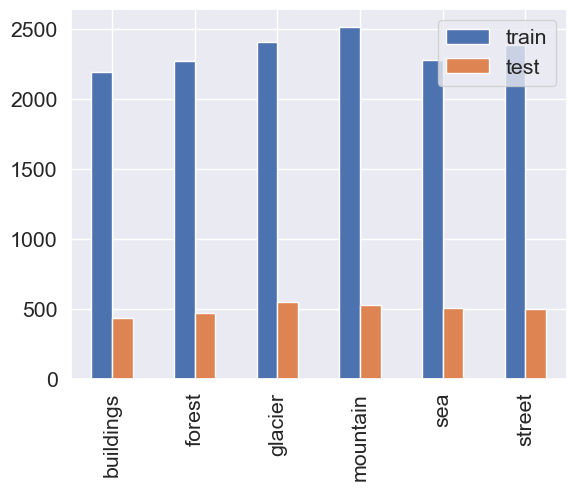

In [111]:
category_label=['buildings','forest', 'glacier','mountain','sea','street']
train_counts =[2191,2271,2404,2512,2274,2382]
test_counts = [437,474,553,525,510,501]
pd.DataFrame({'train': train_counts,
                    'test': test_counts}, 
             index=category_label
            ).plot.bar()
plt.show()

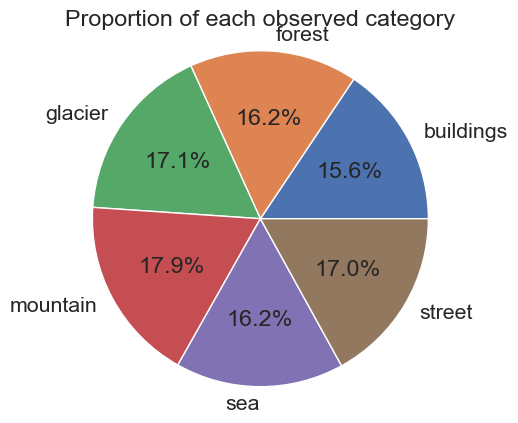

In [112]:
plt.pie(train_counts,
        explode=(0, 0, 0, 0, 0, 0) , 
        labels=category_label,
        autopct='%1.1f%%')
plt.axis('equal')
plt.title('Proportion of each observed category')
plt.show()

## Visualize the data
We can display a random image from the training set.

In [113]:
def display_random_image(category_label, images, labels):
    """
        Display a random image from the images array and its correspond label from the labels array.
    """
    
    index = np.random.randint(images.shape[0])
    plt.figure()
    plt.imshow(images[index])
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.title('Image #{} : '.format(index) + category_label[labels[index]])
    plt.show()

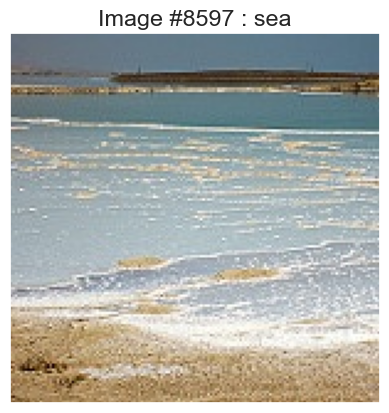

In [114]:
display_random_image(category_label, train_images, train_labels)

We can also display the first 25 images from the training set directly with a loop to get a better view

In [117]:
def display_examples(category_label, images, labels):
    """
        Display 25 images from the images array with its corresponding labels
    """
    
    fig = plt.figure(figsize=(10,10))
    fig.suptitle("Some examples of images of the dataset", fontsize=16)
    for i in range(25):
        plt.subplot(5,5,i+1)
        plt.xticks([])
        plt.yticks([])
        plt.grid(False)
        plt.imshow(images[i], cmap=plt.cm.binary)
        plt.xlabel(category_label[labels[i]])
    plt.show()

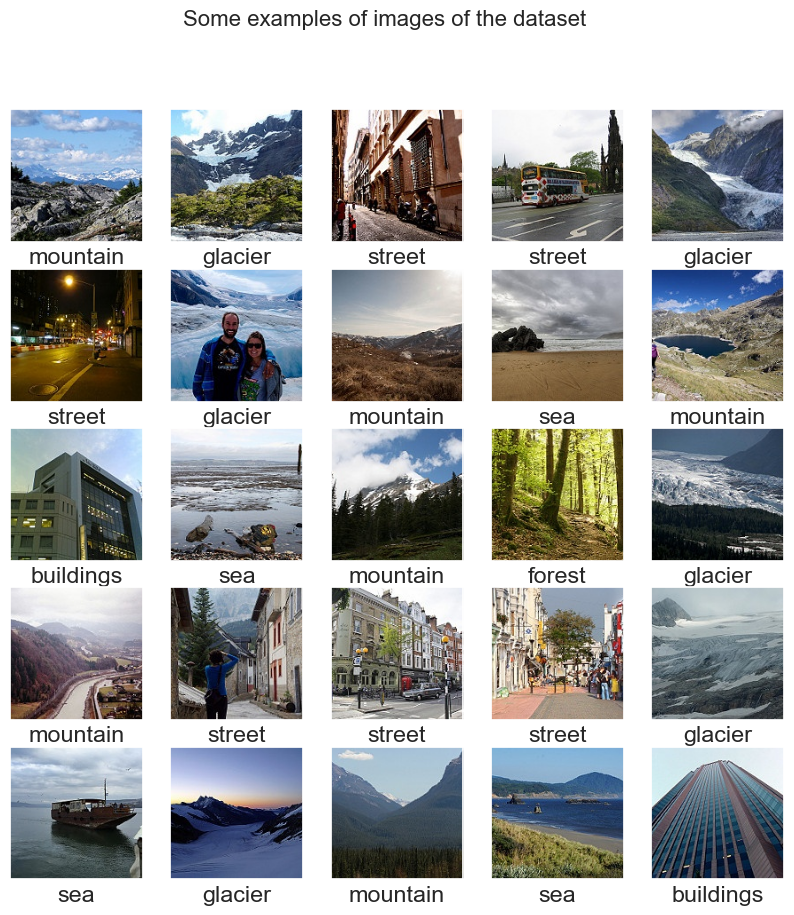

In [118]:
display_examples(category_label, train_images, train_labels)

# Beginner: Simple Model Creation

Steps are:
1. Build the model,
1. Compile the model,
1. Train / fit the data to the model,
1. Evaluate the model on the testing set,
1. Carry out an error analysis of our model.

We can build an easy model composed of different layers such as:
* Conv2D: (32 filters of size 3 by 3) The features will be "extracted" from the image.
* MaxPooling2D: The images get half sized.
* Flatten: Transforms the format of the images from a 2d-array to a 1d-array of 150 150 3 pixel values.
* Relu  : given a value x, returns max(x, 0).
* Softmax: 6 neurons, probability that the image belongs to one of the classes.

In [119]:
model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(32, (3, 3), activation = 'relu', input_shape = (150, 150, 3)), 
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(32, (3, 3), activation = 'relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation=tf.nn.relu),
    tf.keras.layers.Dense(6, activation=tf.nn.softmax)
])

Then, we can compile it with some parameters such as:
* **Optimizer**: adam = RMSProp + Momentum.
What is Momentum and RMSProp ?
* Momentum = takes into account past gradient to have a better update.
* RMSProp = exponentially weighted average of the squares of past gradients.
* **Loss function**: we use sparse categorical crossentropy for classification, each images belongs to one class only

In [120]:
model.compile(optimizer = 'adam', loss = 'sparse_categorical_crossentropy', metrics=['accuracy'])

We fit the model to the data from the training set. The neural network will learn by itself the pattern in order to distinguish each category.

In [121]:
history = model.fit(train_images, train_labels, batch_size=128, epochs=20, validation_split = 0.2)

Epoch 1/20
88/88 [==============================] - 121s 1s/step - loss: 1.3237 - accuracy: 0.5182 - val_loss: 0.8755 - val_accuracy: 0.6726
Epoch 2/20
88/88 [==============================] - 124s 1s/step - loss: 0.8020 - accuracy: 0.7101 - val_loss: 0.7821 - val_accuracy: 0.7303
Epoch 3/20
88/88 [==============================] - 124s 1s/step - loss: 0.6260 - accuracy: 0.7797 - val_loss: 0.6696 - val_accuracy: 0.7528
Epoch 4/20
88/88 [==============================] - 125s 1s/step - loss: 0.4909 - accuracy: 0.8295 - val_loss: 0.7006 - val_accuracy: 0.7449
Epoch 5/20
88/88 [==============================] - 124s 1s/step - loss: 0.3966 - accuracy: 0.8652 - val_loss: 0.7057 - val_accuracy: 0.7531
Epoch 6/20
88/88 [==============================] - 123s 1s/step - loss: 0.2912 - accuracy: 0.9054 - val_loss: 0.6938 - val_accuracy: 0.7706
Epoch 7/20
88/88 [==============================] - 123s 1s/step - loss: 0.1990 - accuracy: 0.9380 - val_loss: 0.7147 - val_accuracy: 0.7706
Epoch 8/20
88

In [122]:
def plot_accuracy_loss(history):
    """
        Plot the accuracy and the loss during the training of the nn.
    """
    fig = plt.figure(figsize=(10,5))

    # Plot accuracy
    plt.subplot(221)
    plt.plot(history.history['accuracy'],'bo--', label = "acc")
    plt.plot(history.history['val_accuracy'], 'ro--', label = "val_acc")
    plt.title("train_acc vs val_acc")
    plt.ylabel("accuracy")
    plt.xlabel("epochs")
    plt.legend()

    # Plot loss function
    plt.subplot(222)
    plt.plot(history.history['loss'],'bo--', label = "loss")
    plt.plot(history.history['val_loss'], 'ro--', label = "val_loss")
    plt.title("train_loss vs val_loss")
    plt.ylabel("loss")
    plt.xlabel("epochs")

    plt.legend()
    plt.show()

In [123]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

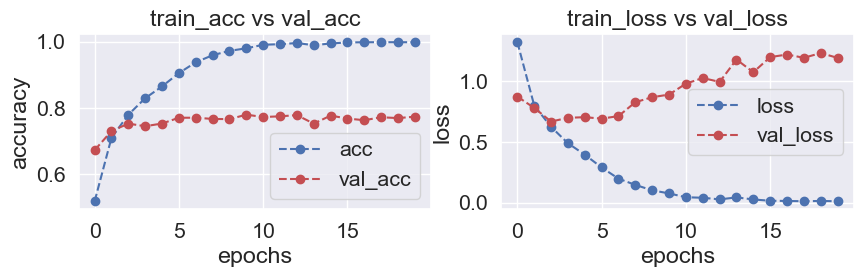

In [124]:
plot_accuracy_loss(history)

We should evaluate the model performance on test set

In [125]:
test_loss = model.evaluate(test_images, test_labels)

94/94 [==============================] - 7s 72ms/step - loss: 1.2307 - accuracy: 0.7773


We see that we achieve 0.76 accuracy on the testing test. We got a slight underfitting :(

Let's see how the classifier is doing on random images.

94/94 [==============================] - 9s 93ms/step


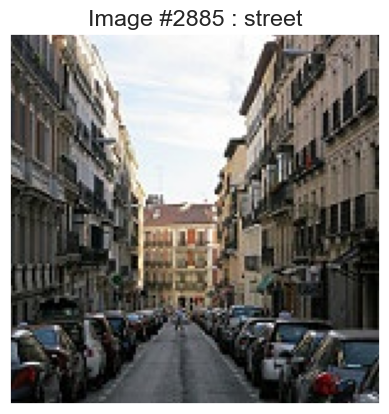

In [126]:
predictions = model.predict(test_images)     # Vector of probabilities
pred_labels = np.argmax(predictions, axis = 1) # We take the highest probability

display_random_image(category_label, test_images, pred_labels)

## Error analysis

We can try to understand on which kind of images the classifier has trouble.

In [128]:
def print_mislabeled_images(class_names, test_images, test_labels, pred_labels):
    """
        Print 25 examples of mislabeled images by the classifier, e.g when test_labels != pred_labels
    """
    BOO = (test_labels == pred_labels)
    mislabeled_indices = np.where(BOO == 0)
    mislabeled_images = test_images[mislabeled_indices]
    mislabeled_labels = pred_labels[mislabeled_indices]

    title = "Some examples of mislabeled images by the classifier:"
    display_examples(class_names,  mislabeled_images, mislabeled_labels)


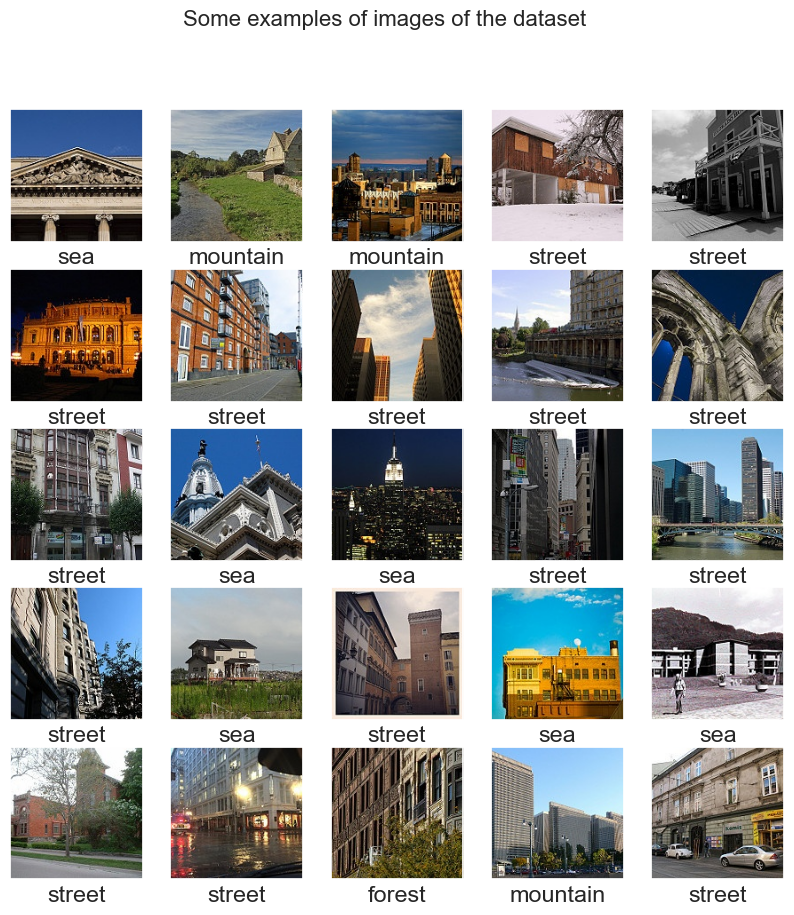

In [129]:
print_mislabeled_images(category_label, test_images, test_labels, pred_labels)

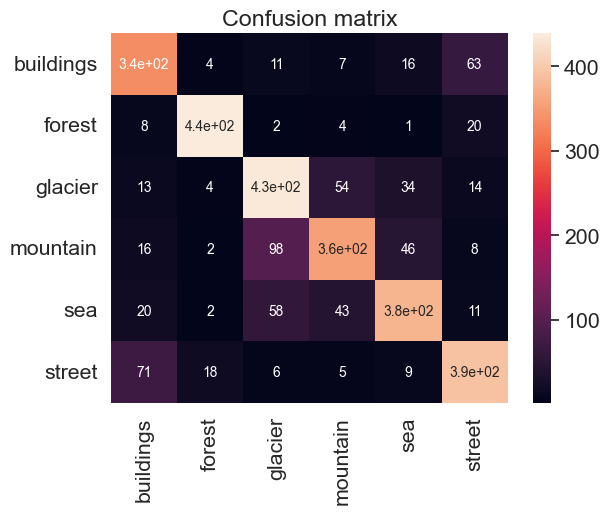

In [130]:
CM = confusion_matrix(test_labels, pred_labels)
ax = plt.axes()
sn.heatmap(CM, annot=True, 
           annot_kws={"size": 10}, 
           xticklabels=category_label, 
           yticklabels=category_label, ax = ax)
ax.set_title('Confusion matrix')
plt.show()

## Conclusion: The classifier has trouble with 2 kinds of images.
It has trouble with street and buildings. Well, it can be understandable as as there are buildings in the street. 
It has also trouble with sea, glacier and moutain as well. It is hard for me to fully distinguish them.
However, it can detects forest very accurately!

In [ ]:
# KVAR:
# CLASSIFICATION REPORT
# EGNA BILDER 

In [ ]:
def processing(path):
    img = cv2.imread(path)
    test1_proc = image.load_img(path , target_size=(150,150))
    test1_proc_1 = image.img_to_array(test1_proc)
    t1 = np.expand_dims(test1_proc ,axis=0)
    t1 = t1/255
    pred_classes = model.predict(t1)
    pred = np.argmax(pred_classes ,axis=1)

    plt.subplot(121)
    pic = Image.open(path) 
    plt.xlabel("Original Image")
    plt.imshow(pic)
    
    
    plt.subplot(122)

    s1 = pd.Series(pred_classes.ravel() , index = training_image.class_indices.keys())
    s1.plot(kind = 'bar' ,figsize = (10,5))
    plt.xlabel("prediction")
    
    plt.show()

    for i in training_image.class_indices:
        if pred == training_image.class_indices[i]:
            print("prediction made by model is :" ,i)